# Methods of De-treding
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [1]:
import nc_time_axis
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import string

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec 
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import time

import os
import sys

from numpy.typing import ArrayLike
from typing import Optional, Callable, List, Tuple, Dict

warnings.filterwarnings('ignore')

In [2]:
import constants
from constants import PlotConfig
sys.path.append(constants.MODULE_DIR)
import sn_plotting
import xarray_class_accessors as xca
import utils
import stats
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon
import plotting_functions
logger = utils.get_notebook_logger()

In [3]:
notebook_number='05'

In [4]:
import dask.distributed as dd
import tempfile

tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dd.Client(local_directory=tempdir.name, memory_limit='16gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44999/status,
Dashboard: http://127.0.0.1:44999/status,Workers: 4
Total threads: 16,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41909,Workers: 4
Dashboard: http://127.0.0.1:44999/status,Total threads: 16
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:36351,Total threads: 4
Dashboard: http://127.0.0.1:39545/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:34843,


# Loading Data

In [5]:
reload(open_ds)

<module 'open_ds' from '/home/563/ab2313/Documents/PhD/modules/open_ds.py'>

In [7]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]

In [8]:
experiment_zec_da = xr.open_mfdataset(os.path.join(
    constants.ZECMIP_LOCAL_DIR, 'regridded', '4xCO2', '*.nc')).tas.compute()

picontrol_zec_da = xr.open_mfdataset(
    os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol', '*.nc'), 
                  use_cftime=True, concat_dim='model', combine='nested').tas.compute()
experiment_zec_da

<xarray.DataArray 'tas' (time: 330, model: 8, lat: 96, lon: 192)>
array([[[[228.19081, 228.11761, 228.03358, ..., 228.34895, 228.30934,
          228.26666],
         [228.63869, 228.32251, 228.18909, ..., 229.39308, 229.22302,
          228.91046],
         [229.635  , 229.27081, 228.94295, ..., 230.75806, 230.35992,
          230.00511],
         ...,
         [260.75046, 260.85168, 260.92606, ..., 260.485  , 260.58914,
          260.66415],
         [260.11743, 260.14868, 260.1803 , ..., 260.0295 , 260.0583 ,
          260.08768],
         [259.65558, 259.6642 , 259.6721 , ..., 259.63025, 259.6385 ,
          259.64682]],

        [[231.1968 , 231.06596, 230.93658, ..., 231.60127, 231.4635 ,
          231.32866],
         [231.0617 , 230.77321, 230.49992, ..., 232.0396 , 231.69922,
          231.37312],
         [231.03154, 230.60631, 230.2147 , ..., 232.57375, 232.02779,
          231.51361],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[229.59404, 229.54118, 229.49236, ..., 229.77473, 229.71037,
          229.6515 ],
         [231.29254, 231.1439 , 231.00423, ..., 231.84636, 231.64787,
          231.46088],
         [231.90709, 231.65538, 231.41377, ..., 232.88017, 232.52441,
          232.19115],
         ...,
         [265.74478, 265.85165, 265.96484, ..., 265.30457, 265.47183,
          265.62253],
         [265.40555, 265.44812, 265.4846 , ..., 265.27594, 265.31555,
          265.3572 ],
         [265.12265, 265.1377 , 265.155  , ..., 265.10107, 265.11038,
          265.114  ]]]], dtype=float32)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0330-12-31 00:00:00
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0

In [9]:
experiment_zec_ds_smean, picontrol_zec_ds_smean = sn.calculate_global_value(
    experiment_zec_da, picontrol_zec_da, experiment_params["variable"])

(None, None)


# Calculations

## Local Points

In [21]:
experiment_zec_da = experiment_zec_da.dropna(dim='time')

In [22]:
trend_da_local = stats.trend_fit(experiment_zec_da, method='polynomial', order=6)

In [37]:
detrended_da_local = experiment_zec_da-trend_da_local

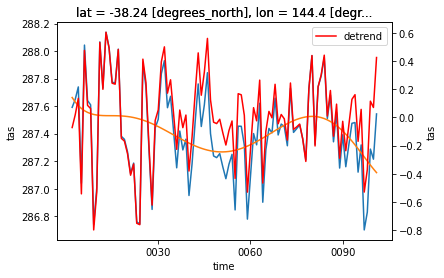

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
experiment_zec_da.sel(lat=-38, lon=144, method='nearest').isel(model=0).plot(label='orig')
trend_da_local.sel(lat=-38, lon=144, method='nearest').isel(model=0).plot(label='fitted')

ax2 = ax.twinx()
detrended_da_local.sel(lat=-38, lon=144, method='nearest').isel(model=0).plot(
    ax=ax2, label='detrend', color='red')
plt.legend()

In [39]:
constants.WINDOWS_OF_INTEREST

[20, 80, 150]

In [41]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/modules/signal_to_noise.py'>

In [ ]:
sn_local_multi_static_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    experiment_zec_da.chunk('auto'),
    picontrol_zec_da.chunk('auto'),
    da_for_noise = detrended_da_local.chunk('auto'),
    logginglevel='INFO', parallel=False, rolling_noise=False,
    windows=constants.WINDOWS_OF_INTEREST)

- sn_kwargs={'windows': [20, 80, 150], 'start_window': 21, 'end_window': None, 'step_window': None, 'rolling_noise': False, 'parallel': False, 'time_slice': None, 'logginglevel': 'INFO'}

Experiment
--------
- windows=[20, 80, 150]
- -- allocate_data_for_noise_calculation
- Dataset for nosie provided
20, - Calculting the rolling signal
80, - Calculting the rolling signal
150, - Calculting the rolling signal

Concatenating objects - PLEASE be patient!
- rolling_noise=False
 - Finished

Control
------

- windows=[20, 80, 150]
- -- allocate_data_for_noise_calculation
- Dataset for nosie provided
20, - Calculting the rolling signal
80, - Calculting the rolling signal
150, - Calculting the rolling signal

Concatenating objects - PLEASE be patient!
- rolling_noise=False
Persist
Calculating bounds
- Calculating Upper and lower control bounds
- Map blocks used


In [ ]:
sn_multi_static_ds = sn_multi_static_ds.compute()

## Global

In [14]:
trend_da1 = stats.trend_fit(abrupt4x_da_smean.isel(time=slice(0,100)), method='polynomial', order=6)
trend_da2 = stats.trend_fit(abrupt4x_da_smean.isel(time=slice(100,None)), method='polynomial', order=6)

In [15]:
double_trend_da = trend_da2.combine_first(trend_da1)
detrended_da = abrupt4x_da_smean - double_trend_da

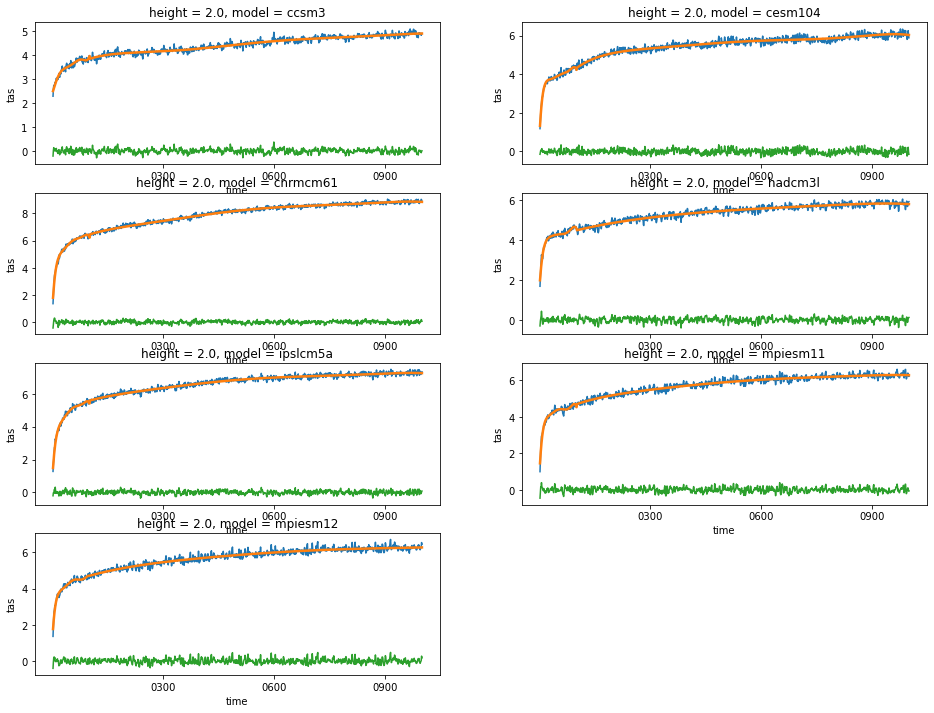

In [16]:
models = double_trend_da.model.values
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(8*ncols, 3*nrows))
for plot_num, model in enumerate(models):
    ax = fig.add_subplot(nrows,ncols,plot_num+1)
    abrupt4x_da_smean.sel(model=model).plot(ax=ax)
    double_trend_da.sel(model=model).plot(ax=ax, linewidth=2.5)
    detrended_da.sel(model=model).plot(ax=ax)
    
    
fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         'methods_05_double_poly_detrend_demonstration'),
           dpi=300)

In [100]:
# trend_da = stats.trend_fit(abrupt4x_da_smean, method='polynomial', order=11)
# detrended_da = abrupt4x_da_smean - trend_da

In [17]:
# prev 2.03 minuts
sn_multi_static_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    abrupt4x_da_smean, control_abrupt_da_smean,
    da_for_noise = detrended_da,
    logginglevel='ERROR', parallel=True, rolling_noise=False, time_slice=(0, 100),
    **constants.MULTI_WINDOW_RUN_PARAMS)


Experiment
--------
11, 15, 19, 27, 23, 31, 35, 39, 43, 47, 59, 51, 55, 63, 67, 71, 29, 37, 13, 17, 21, 53, 25, 61, 41, 45, 33, 49, 69, 57, 65, 73, 75, 79, 83, 91, 87, 95, 99, 103, 107, 111, 119, 115, 123, 127, 131, 135, 77, 81, 89, 85, 97, 93, 105, 101, 121, 109, 113, 129, 133, 125, 137, 117, 139, 143, 147, 151, 141, 149, 145, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

11, 23, 15, 19, 27, 35, 31, 39, 43, 47, 51, 55, 59, 63, 67, 71, 17, 13, 65, 37, 33, 25, 49, 29, 53, 21, 45, 41, 57, 61, 73, 69, 75, 79, 87, 83, 95, 99, 91, 103, 107, 111, 115, 123, 119, 127, 131, 135, 77, 81, 89, 93, 97, 85, 101, 105, 113, 109, 117, 125, 121, 137, 129, 133, 139, 143, 147, 151, 145, 141, 149, 
Concatenating objects - PLEASE be patient!


In [18]:
# prev: 1m 53.8s
sn_multi_rolling_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    abrupt4x_da_smean, control_abrupt_da_smean,
    da_for_noise = detrended_da,#, detrend_kwargs={'method':'polynomial', 'order':3},
    logginglevel='ERROR', parallel=True,
    **constants.MULTI_WINDOW_RUN_PARAMS)


Experiment
--------
11, 15, 19, 23, 27, 35, 31, 39, 43, 47, 51, 55, 59, 63, 67, 71, 25, 21, 17, 29, 13, 33, 57, 37, 53, 41, 73, 61, 49, 45, 65, 69, 75, 79, 83, 87, 91, 77, 95, 99, 107, 103, 111, 81, 115, 123, 131, 119, 127, 135, 89, 85, 93, 97, 101, 105, 139, 113, 109, 133, 117, 125, 129, 137, 143, 121, 147, 151, 145, 141, 149, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

11, 15, 19, 23, 27, 31, 35, 39, 47, 43, 51, 55, 59, 63, 67, 71, 29, 25, 13, 21, 17, 33, 37, 41, 57, 45, 53, 49, 61, 65, 73, 69, 75, 79, 83, 87, 91, 95, 107, 115, 99, 103, 111, 119, 123, 127, 131, 135, 81, 89, 77, 85, 93, 109, 97, 105, 101, 113, 121, 125, 117, 129, 133, 137, 139, 143, 147, 151, 145, 141, 149, 
Concatenating objects - PLEASE be patient!


In [238]:
# Fraction of models stable at each time.
rolling_fraction_stable = sn.get_fracion_stable_ds(sn_multi_rolling_ds)
static_fraction_stable = sn.get_fracion_stable_ds(sn_multi_static_ds)

# Year when models first become stable.
rolling_year_stable = sn.get_stable_year_ds(sn_multi_rolling_ds)
static_year_stable = sn.get_stable_year_ds(sn_multi_static_ds)

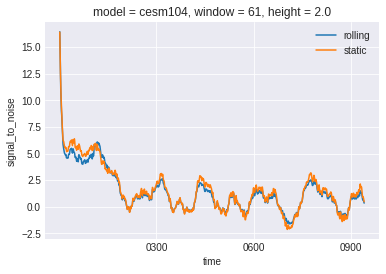

In [104]:
sn_multi_rolling_ds.isel(window=25, model=1).signal_to_noise.plot(label='rolling')
sn_multi_static_ds.isel(window=25, model=1).signal_to_noise.plot(label='static')
plt.legend()

In [207]:
models = rolling_year_stable.model.values
corr_dict = {}
for model in models:
    y1s = static_year_stable.sel(model=model).dropna(dim='window').squeeze().time.values
    y2s = rolling_year_stable.sel(model=model).dropna(dim='window').squeeze().time.values
    corr = spearmanr(y1s, y2s).correlation
    rmse = np.mean(np.sqrt(np.power(y1s-y2s, 2)))
    corr_dict[model] = {'correlation': corr, 'rmse': rmse}

In [208]:
corr_dict

{'ccsm3': {'correlation': 0.7695879301036846, 'rmse': 53.49295774647887},
 'cesm104': {'correlation': 0.8992245114030893, 'rmse': 39.70422535211268},
 'cnrmcm61': {'correlation': 0.8115018527295962, 'rmse': 145.94366197183098},
 'hadcm3l': {'correlation': 0.9280221919559472, 'rmse': 32.19718309859155},
 'ipslcm5a': {'correlation': 0.8659631307056961, 'rmse': 32.436619718309856},
 'mpiesm11': {'correlation': 0.9234161320436366, 'rmse': 30.507042253521128},
 'mpiesm12': {'correlation': 0.9320282400141735, 'rmse': 35.70422535211268}}

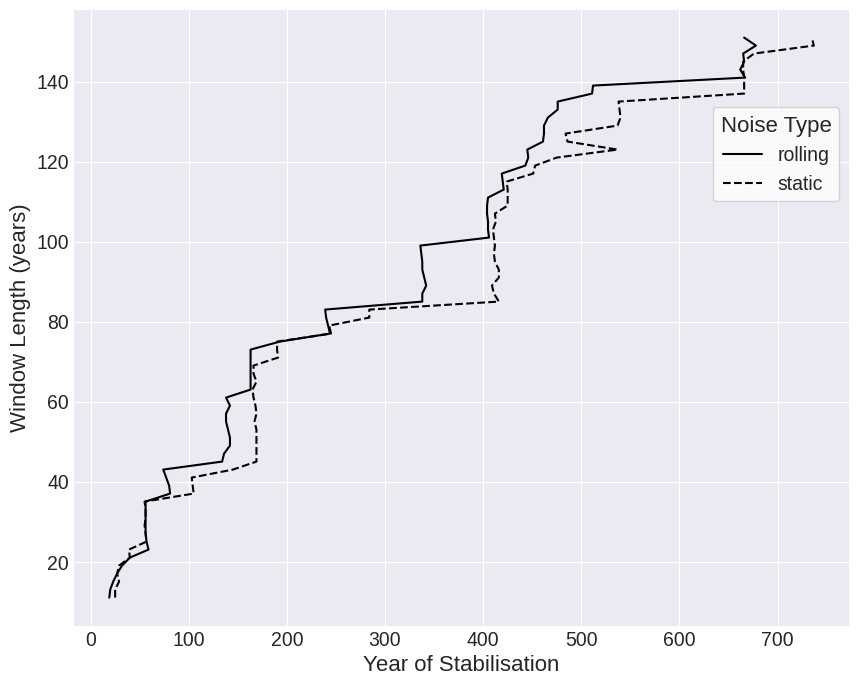

In [375]:
fig, ax = sn_plotting.plot_median_stable_year(static_year_stable, rolling_year_stable)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         'methods_05_stabilisation_year_double_poly_vs_static.png'),
           dpi=300)

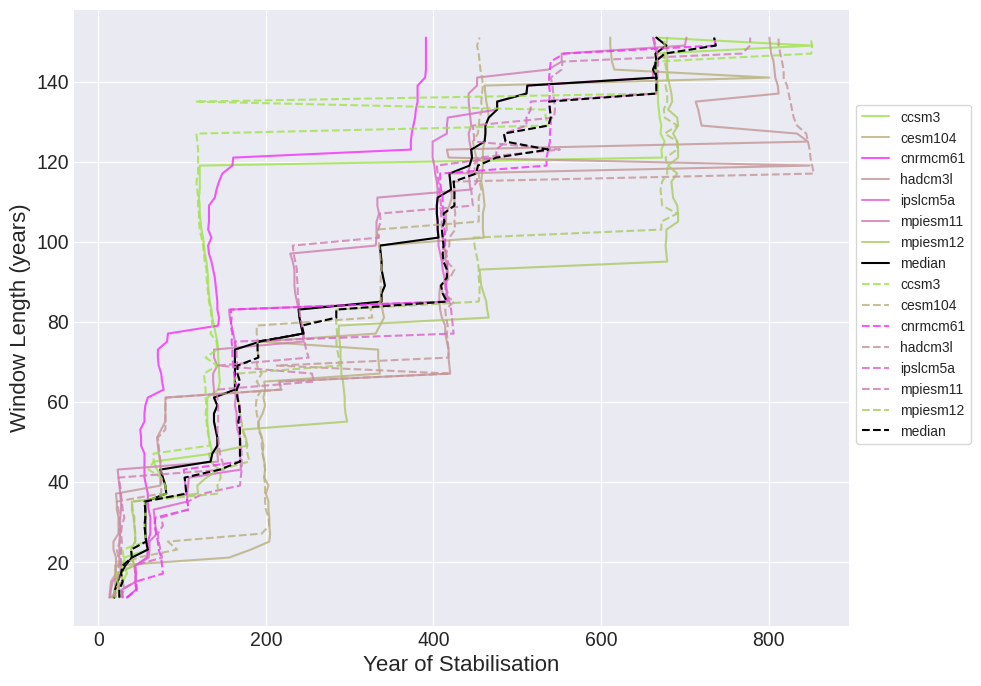

In [376]:
fig, ax = sn_plotting.plot_stable_year_all_models(static_year_stable, linestyle='solid')
fig, ax = sn_plotting.plot_stable_year_all_models(rolling_year_stable, fig=fig, ax=ax, linestyle='dashed')
fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         'methods_05_stabilisation_year_all_model_double_poly_vs_static.png'),
           dpi=300)

In [248]:
units = constants.VARIABLE_INFO[experiment_params["variable"]]["units"]
longname = constants.VARIABLE_INFO[experiment_params["variable"]]['longname']
hemisphere_title = string.capwords(experiment_params['hemisphere'].replace('_', ' '))

mask_title = f'({experiment_params["mask"]} only)' if experiment_params["mask"] else ''

max_effective_length = 1000
models = abrupt4x_da_smean.model.values
levels = np.arange(0, len(models)+1,1)
my_cmap = plotting_functions.create_discrete_cmap('Reds', levels=levels, add_white=True)

longname='Near-Surface\nAir Temperature' , units='$^{\\circ}C$'


In [256]:
spearmanr(np.concatenate(static_fraction_stable.stable), np.concatenate(rolling_fraction_stable.stable))

SpearmanrResult(correlation=0.9459912484097769, pvalue=0.0)

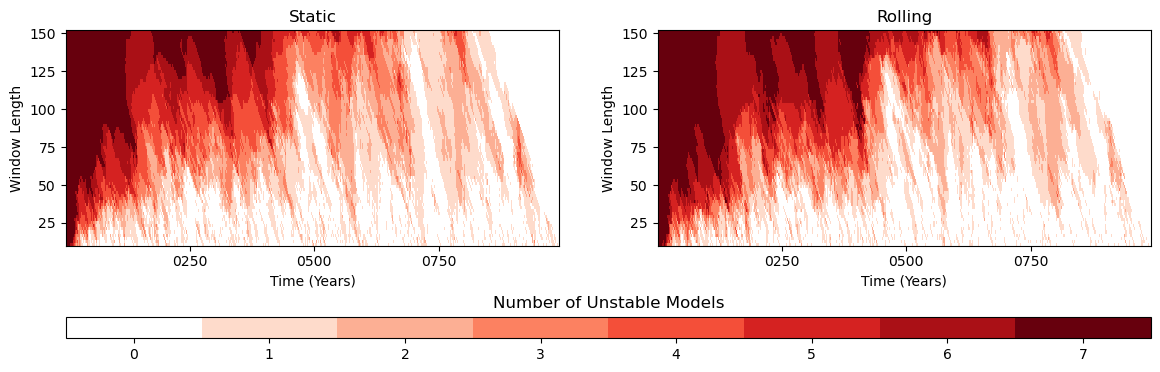

In [374]:
fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(2,2, height_ratios=[1, .1], hspace=0.6)

plot_kwargs = dict(levels=levels, cmap=my_cmap, add_colorbar=False)

ax1 = fig.add_subplot(gs[0,0])
plot = static_fraction_stable.unstable.plot(ax=ax1, **plot_kwargs)
__format_axis(ax1, 'Static')


ax2 = fig.add_subplot(gs[0,1])
rolling_fraction_stable.unstable.plot(ax=ax2, **plot_kwargs)
__format_axis(ax2, 'Rolling')


cax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(plot, cax=cax, orientation='horizontal');
cbar.ax.set_title('Number of Unstable Models');
cbar.set_ticks(cbar_ticks+0.5);
cbar.ax.set_xticklabels(cbar_ticks);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         'methods_05_stabilisation_pattern_double_poly_vs_static.png'),
           dpi=300)

In [372]:
# reload(sn_plot)
# mpl.rcParams.update(mpl.rcParamsDefault)
# fig, ax1, ax2, ax3,cbar = sn_plotting.sn_multi_window_in_time(
#     static_fraction_stable.unstable, static_fraction_stable.stable, abrupt4x_da_smean, 
#     vmin=0, vmax=len(models)+1, step=1, cbartick_offset = 0.5,
#     cmap=my_cmap,
#     extend='neither',
#     xupperlim = max_effective_length,
#     cbar_label= 'Number of Unstable Models', 
#     ax2_ylabel = f'Global Mean\n{longname}\nAnomaly({units})',
#     cbar_ncols = 3, filter_max=True)